In [1]:
# import sys

# from pathlib import Path

# !{sys.executable} -m pip install -e {Path.cwd().parent}
# !{sys.executable} -m pip install datashader matplotlib "napari[all]" pandas seaborn tifffile

In [2]:
import colorcet as cc
import datashader as ds
import matplotlib.pyplot as plt
import napari
import numpy as np
import pandas as pd
import seaborn as sns

from datashader.mpl_ext import dsshow
from scipy.stats import norm
from skimage import measure, morphology
from tifffile import imread

from simutome.estim import CellSlicer

# Parameter estimation from 3D volume

## Image loading

In [3]:
img_file = "../data/kuett_catena_2021/main_her2_brca_model/img.tiff"
mask_file = "../data/kuett_catena_2021/main_her2_brca_model/mask.tiff"
panel_file = "../data/kuett_catena_2021/main_her2_brca_model/panel.csv"
channel_name_col = "name"
channel_label_col = "label"
voxel_size_um = (2.0, 1.0, 1.0)
erosion_footprint = morphology.disk(1.0)[None, :, :]  # None
sectioning_axes = [2, 1, 0]
section_thicknesses_um = [2.0, 4.0, 6.0, 8.0, 10.0]
min_proj_cell_slice_area_um2 = 5.0

In [4]:
# load image
img = imread(img_file)
assert img.ndim == 4
print(f"Loaded image with shape {img.shape}")

# load mask
mask = imread(mask_file)
assert mask.ndim == 3
assert mask.shape[0] == img.shape[0]
assert mask.shape[1:] == img.shape[2:]
print(f"Loaded mask with shape {mask.shape} containing {np.unique(mask).size - 1} labels")

# erode previously dilated pixels to correct for axis inconsistencies
if erosion_footprint is not None:
    mask *= morphology.binary_erosion(mask != 0, erosion_footprint)
    print(f"Eroded mask, now containing {np.unique(mask).size - 1} labels")

# relabel mask to avoid duplicated cell IDs
mask, num_cells = measure.label(mask, return_num=True)
print(f"Relabeled mask containing {num_cells} cells")

# remove border cells to avoid biases
border_cells = np.unique(
    np.concatenate(
        (
            np.unique(mask[[0, -1], :, :]),
            np.unique(mask[:, [0, -1], :]),
            np.unique(mask[:, :, [0, -1]]),
        )
    )
)
mask[np.isin(mask, border_cells)] = 0
num_cells = np.unique(mask).size - 1
print(f"Dropped {len(border_cells) - 1} border cells, now containing {num_cells} cells")

# crop image & mask to speed up computation
ix = np.flatnonzero(np.amax(mask, axis=(0, 1)) != 0)
iy = np.flatnonzero(np.amax(mask, axis=(0, 2)) != 0)
iz = np.flatnonzero(np.amax(mask, axis=(1, 2)) != 0)
img = img[:, :, :, np.amin(ix):np.amax(ix) + 1]
img = img[:, :, np.amin(iy):np.amax(iy) + 1, :]
img = img[np.amin(iz):np.amax(iz) + 1, :, :, :]
mask = mask[:, :, np.amin(ix):np.amax(ix) + 1]
mask = mask[:, np.amin(iy):np.amax(iy) + 1, :]
mask = mask[np.amin(iz):np.amax(iz) + 1, :, :]
print(f"Cropped image and mask to shape {mask.shape}")

# load panel
panel = pd.read_csv(panel_file)
assert len(panel.index) == img.shape[1]
channel_names = panel[channel_name_col].tolist()
channel_labels = panel[channel_label_col].tolist()
print("Channels:")
for i, (channel_name, channel_label) in enumerate(zip(channel_names, channel_labels)):
    print(f"  {i:2d}  {channel_name.ljust(max(len(x) for x in channel_names))}  {channel_label}")
    
cell_slicer = CellSlicer(mask, intensities=img, channel_names=channel_names, voxel_size_um=voxel_size_um)

Loaded image with shape (152, 27, 488, 652)
Loaded mask with shape (152, 488, 652) containing 57916 labels
Eroded mask, now containing 57915 labels
Relabeled mask containing 108596 cells
Dropped 9358 border cells, now containing 99238 cells
Cropped image and mask to shape (150, 486, 650)
Channels:
   0  HH3          Histone H3
   1  CK5          Cytokeratin 5
   2  CK19         Cytokeratin 19
   3  CK8/18       Cytokeratin 8/18
   4  CD68         CD68
   5  KRT14        Keratin 14
   6  SMA          SMA
   7  Vimentin     Vimentin
   8  CD138        CD138 (syndecan-1)
   9  CD3e         CD3 epsilon
  10  pHH3         phospho-Histone H3
  11  HER2         c-erbB-2 (HER2)
  12  CD44         CD44
  13  MPO          Myeloperoxidase (MPO)
  14  CD45         CD45
  15  CD20         CD20
  16  CD8a         CD8a
  17  COL1         Collagen I
  18  Ki-67        Ki-67
  19  pS6          phospho-S6
  20  VWF+CD31     VWF + CD31
  21  E/P-Cad      E/P-Cadherin
  22  CK7          Cytokeratin 7
  23

In [5]:
# viewer = napari.Viewer()
# viewer.add_image(
#     img[:, ::-1, :, :],
#     channel_axis=1,
#     colormap="gray", 
#     name=channel_names[::-1],
#     scale=voxel_size_um, 
#     visible=False,
# );
# viewer.add_labels(
#     mask,
#     name="Cell mask",
#     scale=voxel_size_um,
#     visible=False,
# );

## Cell measurement

In [6]:
# cell_data = cell_slicer.measure_cells(sectioning_axes, progress=True)
# cell_data.insert(1, "sectioning_axis_name", np.array(["z", "y", "x"])[cell_data["sectioning_axis"].values])
# cell_data["cell_radius_um"] = (0.75 * cell_data["cell_volume_um3"] / np.pi) ** (1 / 3)
# cell_data["proj_cell_radius_um"] = (cell_data["proj_cell_area_um2"] / np.pi) ** 0.5
# cell_data.to_csv("cell_data.csv", index=False)

cell_data = pd.read_csv("cell_data.csv")

cell_data

,sectioning_axis,sectioning_axis_name,cell_id,cell_volume_um3,cell_centroid_x_um,cell_centroid_y_um,cell_centroid_z_um,proj_cell_area_um2,proj_cell_centroid_x_um,proj_cell_centroid_y_um,...,mean_proj_cell_intensity_pS6,mean_proj_cell_intensity_VWF+CD31,mean_proj_cell_intensity_E/P-Cad,mean_proj_cell_intensity_CK7,mean_proj_cell_intensity_panCK,mean_proj_cell_intensity_cPARP/Casp3,mean_proj_cell_intensity_DNA1,mean_proj_cell_intensity_DNA2,cell_radius_um,proj_cell_radius_um
0,2,x,2183,180.0,431.100000,3.855556,2.800000,46.0,NaN,3.000000,...,0.304348,2.217391,13.304348,4.000000,205.565216,2.347826,37.782608,72.000000,3.502633,3.826520
1,2,x,2184,66.0,547.575758,4.727273,1.575758,20.0,NaN,2.700000,...,0.100000,1.300000,15.400000,1.100000,128.699997,1.500000,30.500000,58.200001,2.506985,2.523133
2,2,x,2185,146.0,565.821918,4.150685,3.013699,34.0,NaN,3.882353,...,0.176471,2.588235,15.529411,1.235294,87.941177,1.529412,53.647060,109.235291,3.266541,3.289762
3,2,x,2187,42.0,454.285714,12.142857,0.000000,12.0,NaN,2.500000,...,0.666667,1.833333,24.333334,2.500000,109.666664,1.833333,52.666668,106.333336,2.156355,1.954410
4,2,x,2188,68.0,618.058824,12.058824,0.000000,16.0,NaN,3.500000,...,0.375000,2.875000,2.500000,0.000000,1.250000,1.000000,22.125000,55.375000,2.532057,2.256758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297709,0,z,108182,22.0,524.000000,416.000000,298.000000,11.0,1.000000,2.000000,...,0.000000,0.363636,0.454545,0.000000,0.545455,0.000000,4.454545,7.272727,1.738246,1.871205
297710,0,z,108203,46.0,452.000000,429.826087,298.000000,23.0,2.000000,1.826087,...,0.043478,0.260870,0.826087,0.000000,0.130435,0.304348,19.260870,36.739132,2.222746,2.705758
297711,0,z,108234,40.0,565.300000,450.300000,298.000000,20.0,2.300000,3.300000,...,0.050000,0.300000,2.450000,0.200000,37.549999,0.200000,0.900000,0.950000,2.121569,2.523133
297712,0,z,108248,48.0,484.041667,458.291667,298.000000,24.0,2.041667,2.291667,...,0.083333,0.416667,1.875000,0.041667,0.125000,0.291667,7.666667,15.291667,2.254503,2.763953


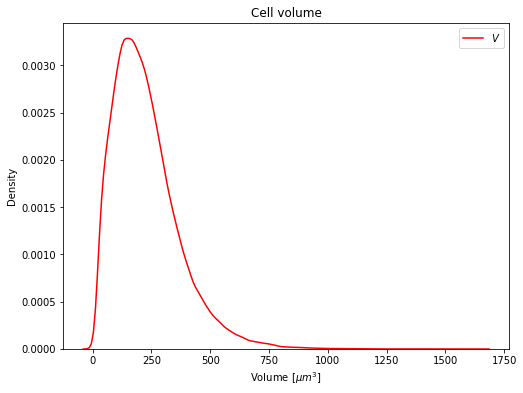

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.kdeplot(
    data=cell_data.groupby("cell_id")[["cell_volume_um3"]].mean(),
    x="cell_volume_um3",
    ax=ax,
    color="red",
)
ax.set_title("Cell volume")
ax.set_xlabel(r"Volume [$\mu m^3$]")
ax.set_ylabel("Density")
ax.legend([r"$V$"])

plt.show()

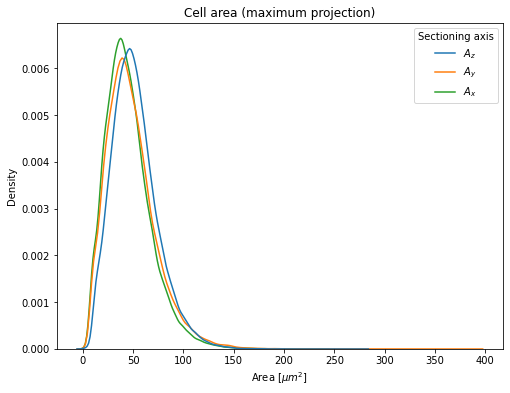

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

p = sns.kdeplot(
    data=cell_data,
    x="proj_cell_area_um2",
    hue="sectioning_axis_name",
    hue_order=["z", "y", "x"],
    ax=ax,
)
p.legend_.set_title("Sectioning axis")
for text, label in zip(p.legend_.texts, [ r"$A_z$", r"$A_y$", r"$A_x$"]):
    text.set_text(label)
ax.set_title("Cell area (maximum projection)")
ax.set_xlabel(r"Area [$\mu m^2$]")
ax.set_ylabel("Density")

plt.show()

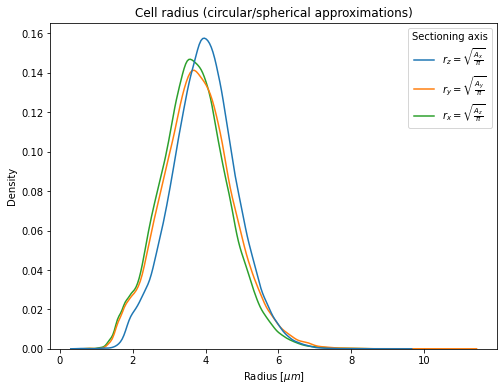

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

p = sns.kdeplot(
    data=cell_data,
    x="proj_cell_radius_um",
    hue="sectioning_axis_name",
    hue_order=["z", "y", "x"],
    ax=ax,
)
p.legend_.set_title("Sectioning axis")
for text, label in zip(
    p.legend_.texts,
    [
        r"$r_z = \sqrt{\frac{A_x}{\pi}}$",
        r"$r_y = \sqrt{\frac{A_y}{\pi}}$",
        r"$r_x = \sqrt{\frac{A_z}{\pi}}$",
        r"$r = \sqrt[3]{\frac{3 V}{4 \pi}}$",
    ],
):
    text.set_text(label)
ax.set_title("Cell radius (circular/spherical approximations)")
ax.set_xlabel(r"Radius [$\mu m$]")
ax.set_ylabel("Density")

plt.show()

## In-silico cell sectioning

In [10]:
# for i, sectioning_axis in enumerate(sectioning_axes):    
#     cell_slice_data = cell_slicer.measure_cell_slices([sectioning_axis], section_thicknesses_um, progress=True)
#     cell_slice_data = cell_slice_data[cell_slice_data["proj_cell_slice_area_um2"] >= min_proj_cell_slice_area_um2]
#     cell_slice_data.insert(1, "sectioning_axis_name", np.array(["z", "y", "x"])[cell_slice_data["sectioning_axis"].values])
#     cell_slice_data["cell_slice_radius_um"] = (0.75 * cell_slice_data["cell_slice_volume_um3"] / np.pi) ** (1.0 / 3.0)
#     cell_slice_data["proj_cell_slice_radius_um"] = (cell_slice_data["proj_cell_slice_area_um2"] / np.pi) ** 0.5
#     cell_slice_data.to_csv("cell_slice_data.csv", header=(i == 0), index=False, mode=("w" if i == 0 else "a"))
# cell_slice_data = pd.read_csv("cell_slice_data.csv")

cell_slice_data = pd.read_csv("cell_slice_data.csv")

cell_slice_data

,sectioning_axis,sectioning_axis_name,section_thickness_um,section_offset_um,cell_id,cell_slice_number,cell_slice_volume_um3,cell_slice_centroid_x_um,cell_slice_centroid_y_um,cell_slice_centroid_z_um,...,mean_proj_cell_slice_intensity_pS6,mean_proj_cell_slice_intensity_VWF+CD31,mean_proj_cell_slice_intensity_E/P-Cad,mean_proj_cell_slice_intensity_CK7,mean_proj_cell_slice_intensity_panCK,mean_proj_cell_slice_intensity_cPARP/Casp3,mean_proj_cell_slice_intensity_DNA1,mean_proj_cell_slice_intensity_DNA2,cell_slice_radius_um,proj_cell_slice_radius_um
0,2,x,2.0,0.0,2347,0,10.0,1.000000,99.600000,3.600000,...,0.000000,0.800000,2.400000,0.400000,30.799999,0.600000,10.000000,18.400000,1.336505,1.784124
1,2,x,2.0,0.0,2420,0,10.0,1.000000,132.400000,0.400000,...,0.000000,1.200000,0.600000,0.200000,2.200000,0.400000,6.400000,10.200000,1.336505,1.784124
2,2,x,2.0,0.0,2837,0,24.0,0.666667,461.500000,1.333333,...,0.125000,0.875000,0.375000,0.000000,0.000000,0.500000,11.250000,22.375000,1.789400,2.256758
3,2,x,2.0,0.0,3564,0,18.0,0.555556,450.111111,7.111111,...,0.600000,1.000000,4.000000,0.200000,0.200000,1.000000,18.600000,36.200001,1.625778,1.784124
4,2,x,2.0,0.0,4085,0,10.0,0.600000,322.200000,4.000000,...,0.000000,1.666667,18.666666,0.000000,63.333332,0.666667,8.333333,17.333334,1.336505,1.381977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9004684,0,z,10.0,8.0,107321,0,24.0,482.000000,443.500000,296.000000,...,0.000000,0.333333,0.666667,0.000000,0.083333,0.250000,1.916667,2.500000,1.789400,1.954410
9004685,0,z,10.0,8.0,107349,0,32.0,292.187500,468.812500,296.000000,...,0.000000,0.750000,0.562500,0.000000,0.125000,0.500000,11.250000,19.625000,1.969490,2.256758
9004686,0,z,10.0,8.0,107357,0,30.0,642.800000,474.066667,296.000000,...,0.133333,0.866667,8.666667,1.266667,78.066666,0.600000,9.600000,17.200001,1.927573,2.185097
9004687,0,z,10.0,8.0,107359,0,48.0,84.291667,475.791667,296.000000,...,1.000000,0.666667,1.083333,0.083333,0.625000,0.083333,7.625000,14.375000,2.254503,2.763953


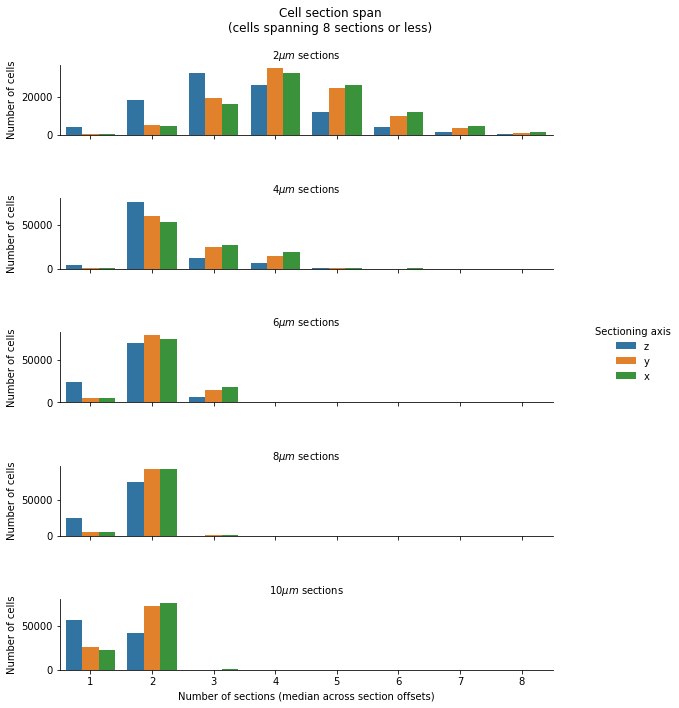

In [11]:
g = sns.catplot(
    data=cell_slice_data.groupby(
        ["sectioning_axis", "sectioning_axis_name", "section_thickness_um", "section_offset_um", "cell_id"]
    ).size().reset_index(name="cell_section_span").groupby(
        ["sectioning_axis", "sectioning_axis_name", "section_thickness_um", "cell_id"]
    )["cell_section_span"].median().round().astype(int).reset_index(name="cell_section_span"),
    x="cell_section_span",
    hue="sectioning_axis_name",
    hue_order=["z", "y", "x"],
    row="section_thickness_um",
    kind="count",
    height=2,
    aspect=8 / 2,
    sharey=False,
)
g.legend.set_title("Sectioning axis")
g.set_titles(row_template=r"${row_name:g} \mu m$ sections")
g.set(
    xlim=(-0.5, 7.5),
    xlabel="Number of sections (median across section offsets)",
    ylabel="Number of cells",
)
g.fig.suptitle("Cell section span\n(cells spanning 8 sections or less)")
g.fig.subplots_adjust(hspace=0.9, top=0.9)

plt.show()

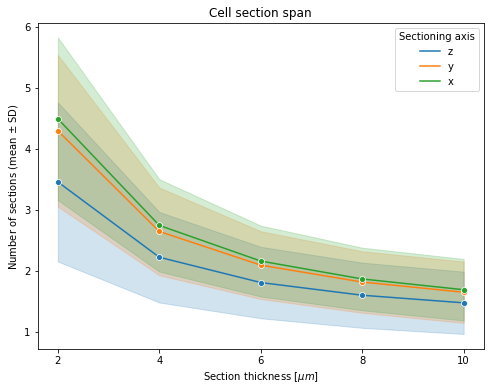

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

p = sns.lineplot(
    data=cell_slice_data.groupby(
        ["sectioning_axis", "sectioning_axis_name", "section_thickness_um", "section_offset_um", "cell_id"]
    ).size().reset_index(name="cell_section_span"),
    x="section_thickness_um",
    y="cell_section_span",
    hue="sectioning_axis_name",
    hue_order=["z", "y", "x"],
    marker="o",
    ci="sd",
    ax=ax,
)
p.legend_.set_title("Sectioning axis")
ax.set_title("Cell section span")
ax.set_xlabel(r"Section thickness [$\mu m$]")
ax.set_ylabel(r"Number of sections (mean $\pm$ SD)")
ax.set_xticks(cell_slice_data["section_thickness_um"].unique())

plt.show()

## Parameter estimation

### Cell exclusion

In [13]:
rng = np.random.default_rng(seed=123)
df = cell_data[cell_data["sectioning_axis_name"] == "z"]

mu_r = df["proj_cell_radius_um"].mean()
sigma_r = df["proj_cell_radius_um"].std()
x_r = np.linspace(df["proj_cell_radius_um"].min(), df["proj_cell_radius_um"].max(), 1000)
y_r = norm.pdf(x_r, mu_r, sigma_r)

t = cell_slice_data["section_thickness_um"].unique()
r = rng.normal(loc=mu_r, scale=sigma_r, size=len(cell_data.index))
s = np.ceil(2 * r[:, None] / t[None, :])

def s_dash(k):
    n1 = np.floor((t[None, :] - ((2 * r[:, None]) % t[None, :])) / k) + 1
    n2 = np.ceil(((2 * r[:, None]) % t[None, :]) / k) - 1
    return (n1 * s + (n2 * (s + 1))) / (n1 + n2)

s_dash_k0 = s_dash(1e-12)
p_exclude = 1 / s_dash_k0

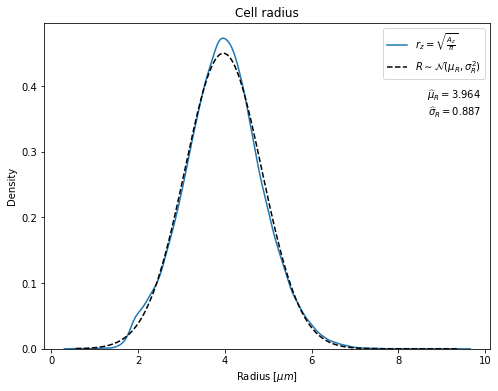

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.kdeplot(
    data=cell_data[cell_data["sectioning_axis_name"] == "z"],
    x="proj_cell_radius_um",
    label=r"$r_z = \sqrt{\frac{A_z}{\pi}}$",
    ax=ax,
)
ax.plot(
    x_r,
    y_r,
    label=r"$R \sim \mathcal{N}(\mu_R, \sigma_R^2)$",
    color="black",
    ls="--",
)
ax.text(
    0.98,
    0.8,
    f"$\\widehat{{\\mu}}_R = {mu_r:.3f}$\n$\\widehat{{\\sigma}}_R = {sigma_r:.3f}$",
    transform=ax.transAxes,
    ha="right",
    va="top",
)
ax.set_title("Cell radius")
ax.set_xlabel(r"Radius [$\mu m$]")
ax.set_ylabel("Density")
ax.legend()

plt.show()

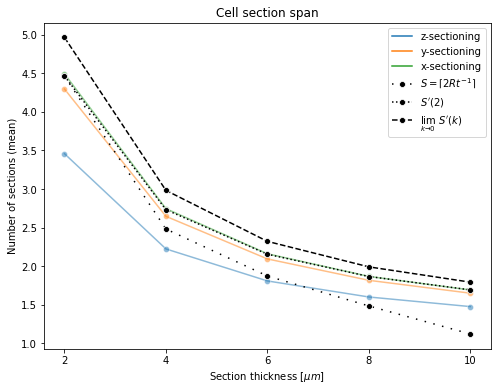

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

p = sns.lineplot(
    data=cell_slice_data.groupby(
        ["sectioning_axis", "sectioning_axis_name", "section_thickness_um", "section_offset_um", "cell_id"]
    ).size().reset_index(name="cell_section_span"),
    x="section_thickness_um",
    y="cell_section_span",
    hue="sectioning_axis_name",
    hue_order=["z", "y", "x"],
    marker="o",
    ci=None,
    ax=ax,
    alpha=0.5,
)
p = sns.lineplot(
    data=pd.DataFrame(data=s, columns=t).melt(var_name="section_thickness_um", value_name="cell_section_span"),
    x="section_thickness_um",
    y="cell_section_span",
    marker="o",
    ci=None,
    ax=ax,
    color="black",
    ls=(0, (1, 5)),
    label=r"$S = \lceil 2 R t^{-1} \rceil$",
)
p = sns.lineplot(
    data=pd.DataFrame(data=s_dash(np.amax(voxel_size_um)), columns=t).melt(var_name="section_thickness_um", value_name="cell_section_span"),
    x="section_thickness_um",
    y="cell_section_span",
    marker="o",
    ci=None,
    ax=ax,
    color="black",
    ls=":",
    label=f"$S'({np.amax(voxel_size_um):g})$",
)
p = sns.lineplot(
    data=pd.DataFrame(data=s_dash_k0, columns=t).melt(var_name="section_thickness_um", value_name="cell_section_span"),
    x="section_thickness_um",
    y="cell_section_span",
    marker="o",
    ci=None,
    ax=ax,
    color="black",
    ls="--",
    label=r"$\lim_{k \to 0}~S'(k)$",
)
for text, label in zip(p.legend_.texts[:3], ["z-sectioning", "y-sectioning", "x-sectioning"]):
    text.set_text(label)
ax.set_title("Cell section span")
ax.set_xlabel(r"Section thickness [$\mu m$]")
ax.set_ylabel(r"Number of sections (mean)")
ax.set_xticks(cell_slice_data["section_thickness_um"].unique())

plt.show()

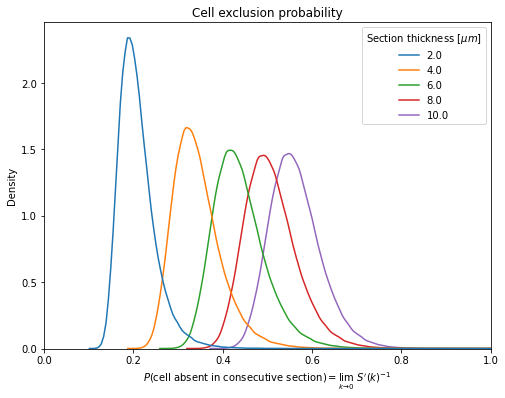

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

df = pd.DataFrame(data=p_exclude, columns=t).melt(var_name="section_thickness_um", value_name="cell_exclusion_probab")
df["section_thickness_um"] = df["section_thickness_um"].astype("category")

p = sns.kdeplot(
    data=df,
    x="cell_exclusion_probab",
    hue="section_thickness_um",
    hue_order=t,
    ax=ax,
)
p.legend_.set_title(r"Section thickness [$\mu m$]")
ax.set_title(f"Cell exclusion probability")
ax.set_xlabel(r"$P($cell absent in consecutive section$) = \lim_{k \to 0}~S'(k)^{-1}$")
ax.set_ylabel(r"Density")
ax.set_xlim(0, 1)

plt.show()

### Cell displacement

In [17]:
# cell_index_cols = ["sectioning_axis", "sectioning_axis_name", "section_thickness_um", "section_offset_um", "cell_id"]
# cell_slice_centroid_cols = ["cell_slice_centroid_x_um", "cell_slice_centroid_y_um", "cell_slice_centroid_z_um"]
# proj_cell_slice_centroid_cols = ["proj_cell_slice_centroid_x_um", "proj_cell_slice_centroid_y_um", "proj_cell_slice_centroid_z_um"]
# cell_slice_centroid_displacement_cols = ["cell_slice_centroid_displacement_x_um", "cell_slice_centroid_displacement_y_um", "cell_slice_centroid_displacement_z_um"]
# proj_cell_slice_centroid_displacement_cols = ["proj_cell_slice_centroid_displacement_x_um", "proj_cell_slice_centroid_displacement_y_um", "proj_cell_slice_centroid_displacement_z_um"]
# cell_slice_displacement_data = cell_slice_data.set_index(cell_index_cols +  ["cell_slice_number"]).sort_index()
# cell_slice_displacement_data = cell_slice_displacement_data[cell_slice_centroid_cols + proj_cell_slice_centroid_cols]
# cell_slice_displacement_data = cell_slice_displacement_data - cell_slice_displacement_data.groupby(cell_index_cols, sort=False).shift()
# cell_slice_displacement_data.rename(columns=dict(zip(cell_slice_centroid_cols, cell_slice_centroid_displacement_cols)), inplace=True)
# cell_slice_displacement_data.rename(columns=dict(zip(proj_cell_slice_centroid_cols, proj_cell_slice_centroid_displacement_cols)), inplace=True)
# cell_slice_displacement_data.dropna(inplace=True, subset=cell_slice_centroid_displacement_cols)
# cell_slice_displacement_data.reset_index(inplace=True)
# cell_slice_displacement_data.to_csv("cell_slice_displacement_data.csv", index=False)

cell_slice_displacement_data = pd.read_csv("cell_slice_displacement_data.csv")

cell_slice_displacement_data

,sectioning_axis,sectioning_axis_name,section_thickness_um,section_offset_um,cell_id,cell_slice_number,cell_slice_centroid_displacement_x_um,cell_slice_centroid_displacement_y_um,cell_slice_centroid_displacement_z_um,proj_cell_slice_centroid_displacement_x_um,proj_cell_slice_centroid_displacement_y_um,proj_cell_slice_centroid_displacement_z_um
0,0,z,2.0,0.0,2183,1,0.658120,0.190171,2.0,1.658120,1.190171,NaN
1,0,z,2.0,0.0,2183,2,0.505051,0.255051,2.0,-0.494949,0.255051,NaN
2,0,z,2.0,0.0,2183,3,0.856061,-0.435606,2.0,-1.143939,-1.435606,NaN
3,0,z,2.0,0.0,2184,1,0.005495,1.285714,2.0,2.005495,0.285714,NaN
4,0,z,2.0,0.0,2185,2,-0.399826,-0.381533,2.0,0.600174,1.618467,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4548450,2,x,10.0,8.0,107879,1,3.256410,0.141026,0.0,NaN,0.000000,0.0
4548451,2,x,10.0,8.0,107903,1,1.875000,-0.750000,0.0,NaN,-1.500000,0.0
4548452,2,x,10.0,8.0,107946,1,1.428571,-0.214286,0.0,NaN,0.000000,0.0
4548453,2,x,10.0,8.0,108149,1,2.053571,-0.464286,0.0,NaN,0.000000,0.0


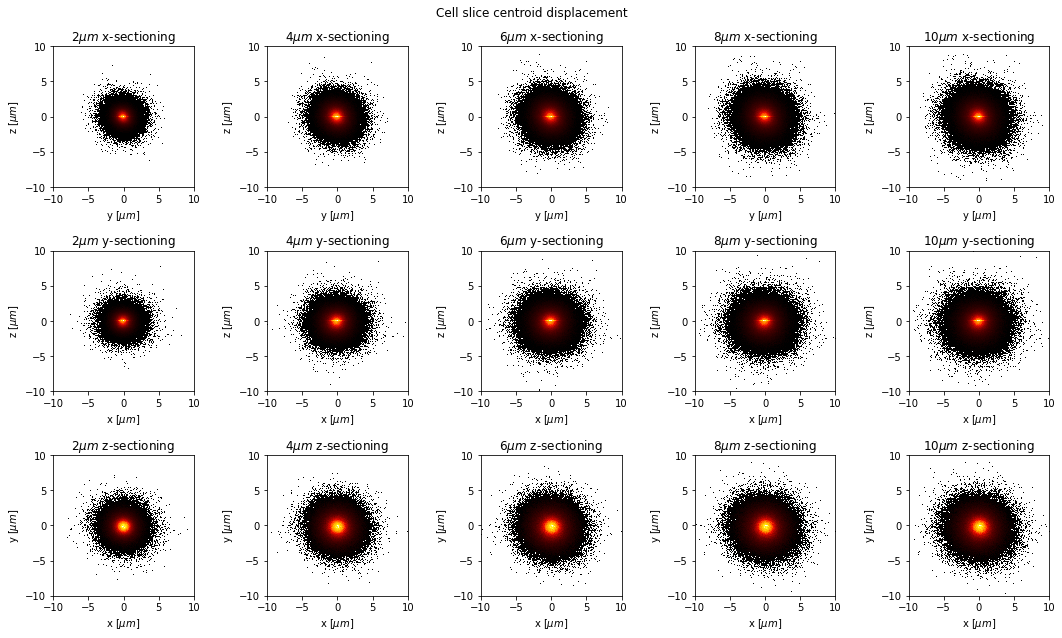

In [18]:
sectioning_axis_names = ("x", "y", "z")
fig, axes = plt.subplots(nrows=3, ncols=cell_slice_displacement_data["section_thickness_um"].nunique(), figsize=(15, 9))
for (i, row_axes), sectioning_axis_name in zip(enumerate(axes), sectioning_axis_names):
    x, y = tuple(a for a in sectioning_axis_names if a != sectioning_axis_name)
    df = cell_slice_displacement_data[cell_slice_displacement_data["sectioning_axis_name"] == sectioning_axis_name]
    for (j, ax), (section_thickness_um, g) in zip(enumerate(row_axes), df.groupby("section_thickness_um")):
        dsshow(g, ds.Point(f"cell_slice_centroid_displacement_{x}_um", f"cell_slice_centroid_displacement_{y}_um"), cmap=cc.fire, ax=ax)
        ax.set_title(f"${section_thickness_um:g} \\mu m$ {sectioning_axis_name}-sectioning")
        ax.set_xlabel(f"{x} [$\\mu m$]")
        ax.set_ylabel(f"{y} [$\\mu m$]")
        ax.set_ylim(-10, 10)
        ax.set_xlim(-10, 10)
plt.suptitle("Cell slice centroid displacement")
plt.tight_layout()
plt.show()

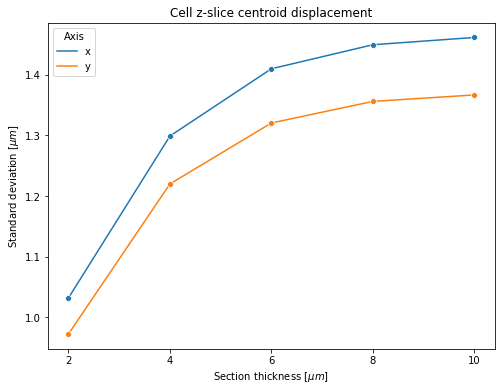

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

p = sns.lineplot(
    data=cell_slice_displacement_data[cell_slice_displacement_data["sectioning_axis_name"] == "z"].melt(
        id_vars=["sectioning_axis", "sectioning_axis_name", "section_thickness_um", "section_offset_um", "cell_id", "cell_slice_number"],
        value_vars=["cell_slice_centroid_displacement_x_um", "cell_slice_centroid_displacement_y_um"],
        var_name="cell_slice_centroid_displacement_column",
        value_name="cell_slice_centroid_displacement_um",
    ),
    x="section_thickness_um",
    y="cell_slice_centroid_displacement_um",
    hue="cell_slice_centroid_displacement_column",
    hue_order=["cell_slice_centroid_displacement_x_um", "cell_slice_centroid_displacement_y_um"],
    estimator=np.std,
    ci=None,
    ax=ax,
    marker="o",
)
p.legend_.set_title("Axis")
for text, label in zip(p.legend_.texts, ["x", "y"]):
    text.set_text(label)
ax.set_title("Cell z-slice centroid displacement")
ax.set_xlabel(r"Section thickness [$\mu m$]")
ax.set_ylabel(r"Standard deviation [$\mu m$]")
ax.set_xticks(cell_slice_displacement_data["section_thickness_um"].unique())

plt.show()

In [20]:
cell_slice_displacement_data[cell_slice_displacement_data["sectioning_axis_name"] == "z"].groupby("section_thickness_um")[
    ["cell_slice_centroid_displacement_x_um", "cell_slice_centroid_displacement_y_um"]
].mean()

,cell_slice_centroid_displacement_x_um,cell_slice_centroid_displacement_y_um
section_thickness_um,,
2.0,-0.003023,-0.132647
4.0,-0.008981,-0.210557
6.0,-0.013018,-0.245893
8.0,-0.014237,-0.258980
10.0,-0.015415,-0.264913


In [21]:
cell_slice_displacement_data[cell_slice_displacement_data["sectioning_axis_name"] == "z"].groupby("section_thickness_um")[
    ["cell_slice_centroid_displacement_x_um", "cell_slice_centroid_displacement_y_um"]
].cov()

cell_slice_centroid_displacement_x_um  \
section_thickness_um                                                                                
2.0                  cell_slice_centroid_displacement_x_um                               1.064922   
                     cell_slice_centroid_displacement_y_um                              -0.037679   
4.0                  cell_slice_centroid_displacement_x_um                               1.686784   
                     cell_slice_centroid_displacement_y_um                              -0.059240   
6.0                  cell_slice_centroid_displacement_x_um                               1.987132   
                     cell_slice_centroid_displacement_y_um                              -0.072440   
8.0                  cell_slice_centroid_displacement_x_um                               2.100294   
                     cell_slice_centroid_displacement_y_um                              -0.078452   
10.0                 cell_slice_centroid_displacement_x_um                               2.135266   
                     cell_slice_centroid_displacement_y_um                              -0.081272   

                                                            cell_slice_centroid_displacement_y_um  
section_thickness_um                                                                               
2.0                  cell_slice_centroid_displacement_x_um                              -0.037679  
                     cell_slice_centroid_displacement_y_um                               0.945738  
4.0                  cell_slice_centroid_displacement_x_um                              -0.059240  
                     cell_slice_centroid_displacement_y_um                               1.487934  
6.0                  cell_slice_centroid_displacement_x_um                              -0.072440  
                     cell_slice_centroid_displacement_y_um                               1.743214  
8.0                  cell_slice_centroid_displacement_x_um                              -0.078452  
                     cell_slice_centroid_displacement_y_um                               1.838385  
10.0                 cell_slice_centroid_displacement_x_um                              -0.081272  
                     cell_slice_centroid_displacement_y_um                               1.867348

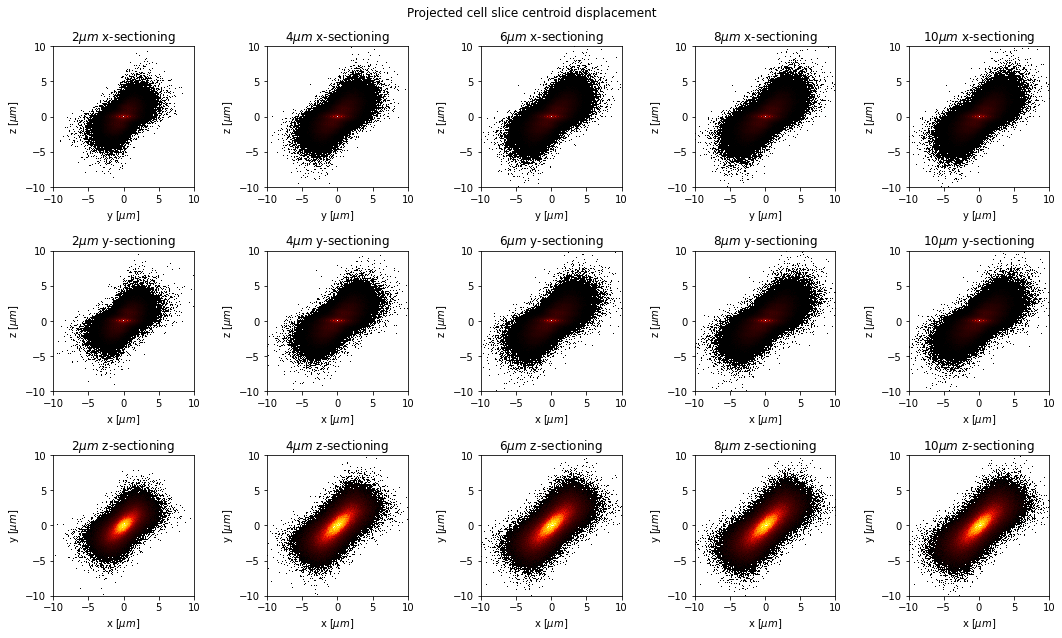

In [22]:
sectioning_axis_names = ("x", "y", "z")
fig, axes = plt.subplots(nrows=3, ncols=cell_slice_displacement_data["section_thickness_um"].nunique(), figsize=(15, 9))
for (i, row_axes), sectioning_axis_name in zip(enumerate(axes), sectioning_axis_names):
    x, y = tuple(a for a in sectioning_axis_names if a != sectioning_axis_name)
    df = cell_slice_displacement_data[cell_slice_displacement_data["sectioning_axis_name"] == sectioning_axis_name]
    for (j, ax), (section_thickness_um, g) in zip(enumerate(row_axes), df.groupby("section_thickness_um")):
        dsshow(g, ds.Point(f"proj_cell_slice_centroid_displacement_{x}_um", f"proj_cell_slice_centroid_displacement_{y}_um"), cmap=cc.fire, ax=ax)
        ax.set_title(f"${section_thickness_um:g} \\mu m$ {sectioning_axis_name}-sectioning")
        ax.set_xlabel(f"{x} [$\\mu m$]")
        ax.set_ylabel(f"{y} [$\\mu m$]")
        ax.set_ylim(-10, 10)
        ax.set_xlim(-10, 10)
plt.suptitle("Projected cell slice centroid displacement")
plt.tight_layout()
plt.show()

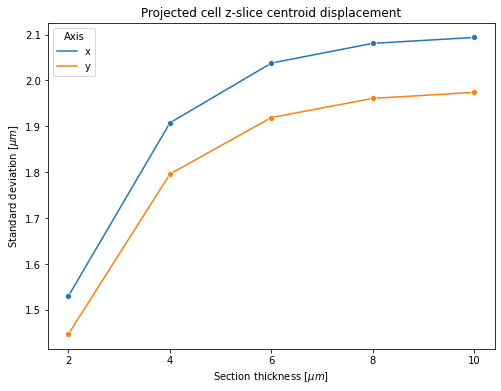

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

p = sns.lineplot(
    data=cell_slice_displacement_data[cell_slice_displacement_data["sectioning_axis_name"] == "z"].melt(
        id_vars=["sectioning_axis", "sectioning_axis_name", "section_thickness_um", "section_offset_um", "cell_id", "cell_slice_number"],
        value_vars=["proj_cell_slice_centroid_displacement_x_um", "proj_cell_slice_centroid_displacement_y_um"],
        var_name="proj_cell_slice_centroid_displacement_column",
        value_name="proj_cell_slice_centroid_displacement_um",
    ),
    x="section_thickness_um",
    y="proj_cell_slice_centroid_displacement_um",
    hue="proj_cell_slice_centroid_displacement_column",
    hue_order=["proj_cell_slice_centroid_displacement_x_um", "proj_cell_slice_centroid_displacement_y_um"],
    estimator=np.std,
    ci=None,
    ax=ax,
    marker="o",
)
p.legend_.set_title("Axis")
for text, label in zip(p.legend_.texts, ["x", "y"]):
    text.set_text(label)
ax.set_title("Projected cell z-slice centroid displacement")
ax.set_xlabel(r"Section thickness [$\mu m$]")
ax.set_ylabel(r"Standard deviation [$\mu m$]")
ax.set_xticks(cell_slice_displacement_data["section_thickness_um"].unique())

plt.show()

In [24]:
cell_slice_displacement_data[cell_slice_displacement_data["sectioning_axis_name"] == "z"].groupby("section_thickness_um")[
    ["proj_cell_slice_centroid_displacement_x_um", "proj_cell_slice_centroid_displacement_y_um"]
].mean()

,proj_cell_slice_centroid_displacement_x_um,proj_cell_slice_centroid_displacement_y_um
section_thickness_um,,
2.0,0.003985,0.002093
4.0,0.009743,0.009768
6.0,0.012533,0.013668
8.0,0.011696,0.013430
10.0,0.011270,0.012500


In [25]:
cell_slice_displacement_data[cell_slice_displacement_data["sectioning_axis_name"] == "z"].groupby("section_thickness_um")[
    ["proj_cell_slice_centroid_displacement_x_um", "proj_cell_slice_centroid_displacement_y_um"]
].cov()

proj_cell_slice_centroid_displacement_x_um  \
section_thickness_um                                                                                          
2.0                  proj_cell_slice_centroid_displacement_x_um                                    2.341891   
                     proj_cell_slice_centroid_displacement_y_um                                    1.407049   
4.0                  proj_cell_slice_centroid_displacement_x_um                                    3.639200   
                     proj_cell_slice_centroid_displacement_y_um                                    2.410274   
6.0                  proj_cell_slice_centroid_displacement_x_um                                    4.153177   
                     proj_cell_slice_centroid_displacement_y_um                                    2.842610   
8.0                  proj_cell_slice_centroid_displacement_x_um                                    4.330343   
                     proj_cell_slice_centroid_displacement_y_um                                    2.998631   
10.0                 proj_cell_slice_centroid_displacement_x_um                                    4.383738   
                     proj_cell_slice_centroid_displacement_y_um                                    3.048995   

                                                                 proj_cell_slice_centroid_displacement_y_um  
section_thickness_um                                                                                         
2.0                  proj_cell_slice_centroid_displacement_x_um                                    1.407049  
                     proj_cell_slice_centroid_displacement_y_um                                    2.095079  
4.0                  proj_cell_slice_centroid_displacement_x_um                                    2.410274  
                     proj_cell_slice_centroid_displacement_y_um                                    3.226070  
6.0                  proj_cell_slice_centroid_displacement_x_um                                    2.842610  
                     proj_cell_slice_centroid_displacement_y_um                                    3.683404  
8.0                  proj_cell_slice_centroid_displacement_x_um                                    2.998631  
                     proj_cell_slice_centroid_displacement_y_um                                    3.845288  
10.0                 proj_cell_slice_centroid_displacement_x_um                                    3.048995  
                     proj_cell_slice_centroid_displacement_y_um                                    3.897202